## Neural Networks in PyMC3 estimated with Variational Inference
(c) 2016 by Thomas Wiecki

## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [127]:
X, Y = sklearn.datasets.make_blobs(centers=2, random_state=3)
X = scale(X)

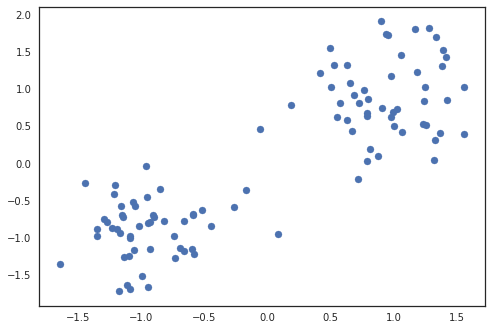

In [128]:
plt.scatter(X[:, 0], X[:, 1])

In [144]:
X_unc = np.ones_like(X) * 1.
X_unc[:, 0] = .5

In [124]:
prob.tag.test_value.shape

(100, 2)

In [145]:
with pm.Model() as logistic_regression:
    inputs = pm.Normal('inputs', mu=X, sd=X_unc, shape=X.shape)
    coeffs = pm.Normal('beta', mu=0, sd=1, shape=2)
    
    linear = pm.math.dot(inputs, coeffs)
    prob = pm.math.sigmoid(linear)
    obs = pm.Bernoulli('obs', p=prob, observed=Y)
    
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mean_field = pm.fit(method='advi', n=50000,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])
    
    out_sample = (mean_field.sample_node(prob, size=100, more_replacements={inputs: grid_2d}) > .5)

Average Loss = 18.477: 100%|██████████| 50000/50000 [00:17<00:00, 2836.78it/s]
Finished [100%]: Average Loss = 18.476


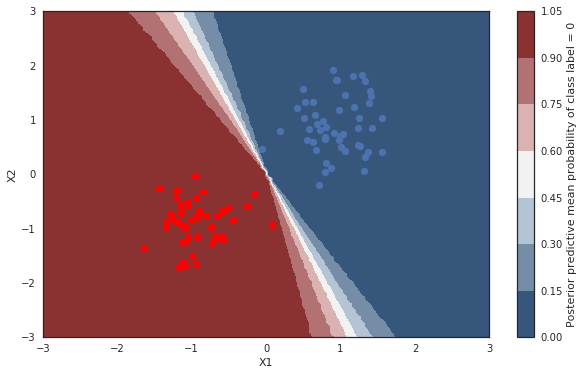

In [146]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

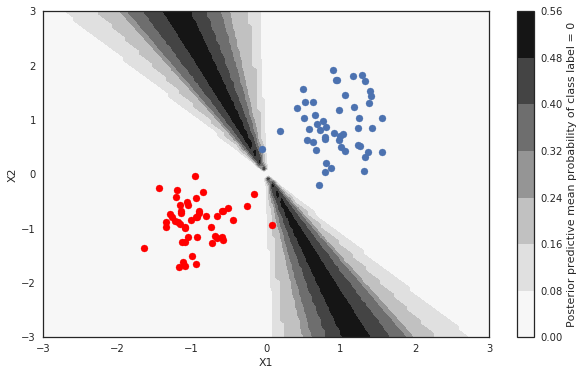

In [147]:
cmap = sns.choose_light_palette(250, 12)#, as_cmap=True)#, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [14]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)

In [3]:
def uncertainty_surf(x, a=(2, 3), b=(.2, .3), min_val=.1):
    out_1 = a[0] + x[:, 0] * b[0] 
    out_2 = a[1] + x[:, 1] * b[1]
    out_1[out_1 < min_val] = min_val
    out_2[out_2 < min_val] = min_val
    return np.dstack([out_1, out_2])[0, ...]

In [4]:
X.shape

(1000, 2)

In [5]:
X_uc = uncertainty_surf(X)
X_uc.shape

(1000, 2)

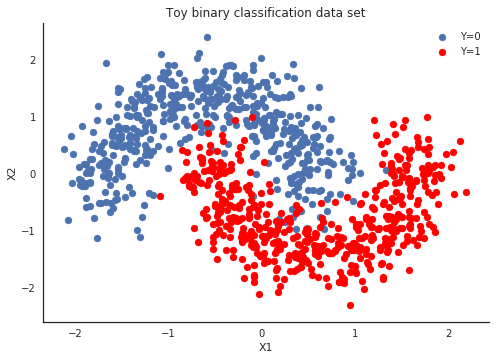

In [7]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

In [45]:
X_uc

array([[ 2.35556116,  3.18227683],
       [ 2.29235303,  2.86573431],
       [ 1.83620546,  3.18221856],
       ..., 
       [ 1.96900957,  2.50669307],
       [ 1.92888424,  2.89662248],
       [ 1.99622199,  2.56440378]])

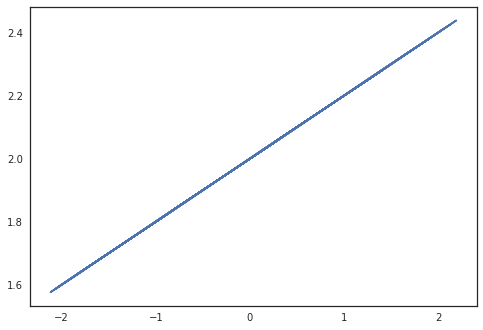

In [46]:
plt.plot(X[:, 0], X_uc[:, 0])

TypeError: val must be a float or nonzero sequence of floats

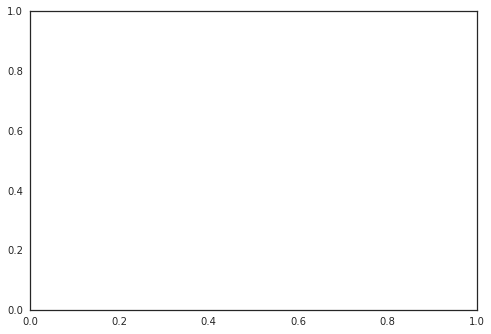

In [44]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], linewidths=X_uc[])
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [12]:
out_sample.eval().shape

(100, 3)

In [101]:
n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

#input_dist = theano.shared(X)

with pm.Model() as neural_network:
    input_dist = pm.Normal('inputs', mu=X, sd=X_uc*.1, 
                           shape=X.shape)
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden lay2er to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(input_dist, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=Y)

In [102]:
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mean_field = pm.fit(method='advi', n=50000,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])

Average Loss = 229.14: 100%|██████████| 50000/50000 [01:23<00:00, 601.45it/s]
Finished [100%]: Average Loss = 229.23


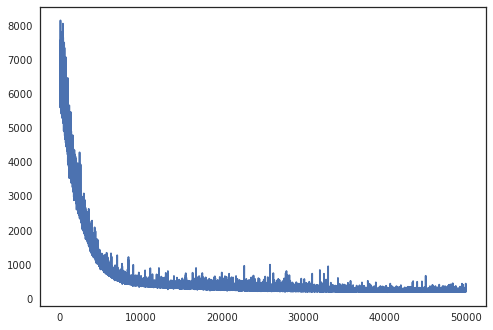

In [103]:
plt.plot(mean_field.hist);

In [85]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X1_grid, X2_grid = grid

In [104]:
with neural_network:
    out_sample = (mean_field.sample_node(act_out, size=100, more_replacements={input_dist: grid_2d}) > .5)

In [56]:
out_sample.eval().std(axis=0)

array([ 0.49638695,  0.49638695,  0.49638695, ...,  0.49638695,
        0.49638695,  0.49638695])

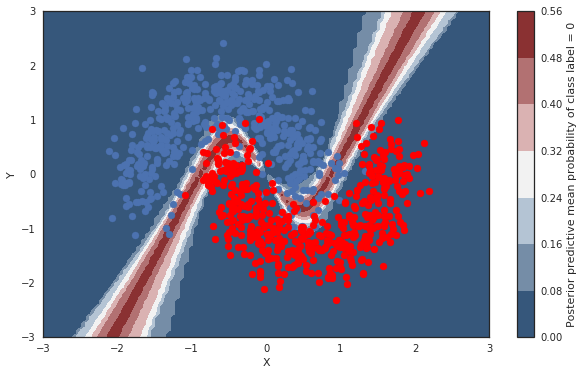

In [106]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().std(axis=0).reshape(100, 100), cmap=cmap)
#contour = ax.contourf(X1_grid, X2_grid, out_sample.eval().mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [28]:
trace = mean_field.sample(100)

In [30]:
with neural_network:
    ppc = pm.sample_ppc(trace);

100%|██████████| 100/100 [00:00<00:00, 168.47it/s]


In [40]:
ppc['out']

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 1, 1],
       ..., 
       [0, 1, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 0]])

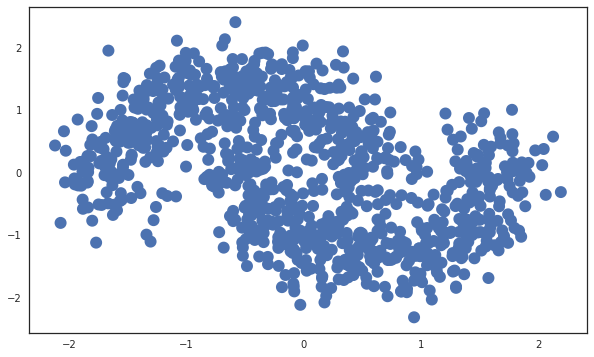

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.scatter(X[Y==0, 0], X[Y==0, 1])
#ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
ax.scatter(X[:, 0], X[:, 1], linewidths=out_sample.eval().std(axis=1) * 10)

In [115]:
Y_pred = np.mean(out_sample.eval(), axis=0)

In [67]:
out_sample.eval().std(axis=1).shape

(100,)

In [ ]:
with neural_network:
    mean_field = pm.fit(method='advi', n=50000,
                       callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative')])
    approx = inference.approx
    test_probs = approx.sample_node(act_out, more_replacements={Xt: grid_2d})
    eval_tracker = pm.callbacks.Tracker(
        test_probs=test_probs.eval,
    )
    inference.fit(method='advi', n=50000,
                  callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative'),
                             eval_tracker])

In [ ]:
with neural_network:
    inference = pm.ADVI()
    approx = inference.approx
    test_probs = approx.sample_node(p, more_replacements={Xt: grid_2d})
    eval_tracker = pm.callbacks.Tracker(
        test_probs=test_probs.eval,
    )
    inference.fit(method='advi', n=50000,
                  callbacks=[pm.callbacks.CheckParametersConvergence(diff='relative'),
                             eval_tracker])

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We use [`sample_ppc()`](http://pymc-devs.github.io/pymc3/api.html#pymc3.sampling.sample_ppc) to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [7]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

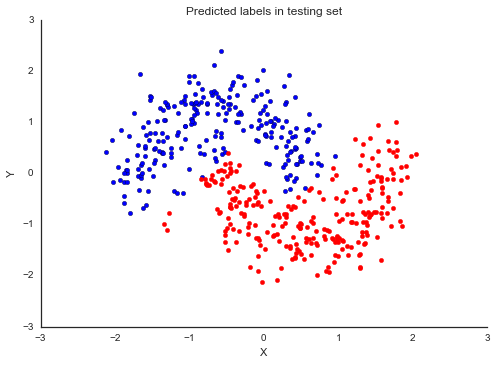

In [8]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [9]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.19999999999999%


Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [11]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

### Probability surface

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

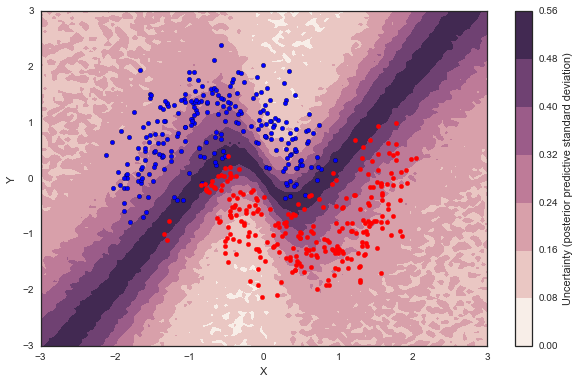

In [27]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI: Scaling data size

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [43]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train), 
    create_minibatch(Y_train),
)

total_size = len(Y_train)

While the above might look a bit daunting, I really like the design. Especially the fact that you define a generator allows for great flexibility. In principle, we could just pool from a database there and not have to keep all the data in RAM. 

Lets pass those to `advi_minibatch()`:

In [48]:
%%time

with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Iteration 0 [0%]: ELBO = -311.63
Iteration 5000 [10%]: ELBO = -162.34
Iteration 10000 [20%]: ELBO = -70.49
Iteration 15000 [30%]: ELBO = -153.64
Iteration 20000 [40%]: ELBO = -164.07
Iteration 25000 [50%]: ELBO = -135.05
Iteration 30000 [60%]: ELBO = -240.99
Iteration 35000 [70%]: ELBO = -111.71
Iteration 40000 [80%]: ELBO = -87.55
Iteration 45000 [90%]: ELBO = -97.5
Finished [100%]: ELBO = -75.31
CPU times: user 17.4 s, sys: 56 ms, total: 17.5 s
Wall time: 17.5 s


In [49]:
with neural_network:    
    trace = pm.variational.sample_vp(v_params, draws=5000)

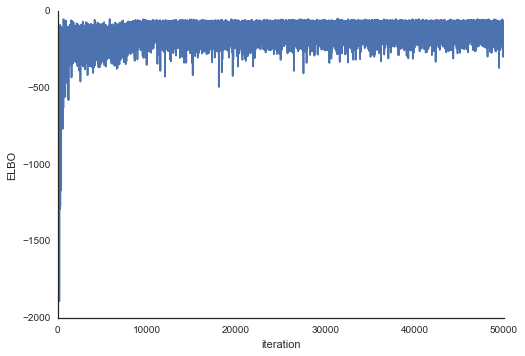

In [50]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

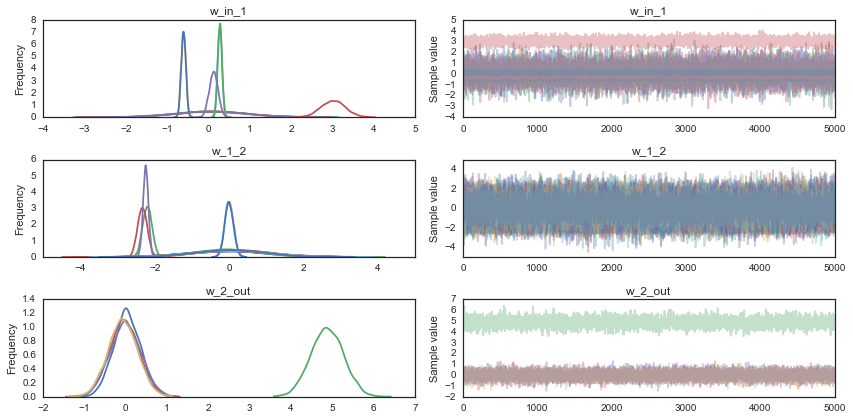

In [51]:
pm.traceplot(trace);

## Summary

Hopefully this blog post demonstrated a very powerful new inference algorithm available in [PyMC3](http://pymc-devs.github.io/pymc3/): [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi). I also think bridging the gap between Probabilistic Programming and Deep Learning can open up many new avenues for innovation in this space, as discussed above. Specifically, a hierarchical neural network sounds pretty bad-ass. These are really exciting times.

## Next steps

[`Theano`](http://deeplearning.net/software/theano/), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. Ideally, we wouldn't have to build the models by hand as I did above, but use the convenient syntax of `Lasagne` to construct the architecture, define our priors, and run ADVI. 

While we haven't successfully run `PyMC3` on the GPU yet, it should be fairly straight forward (this is what `Theano` does after all) and further reduce the running time significantly. If you know some `Theano`, this would be a great area for contributions!

You might also argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets.

I also presented some of this work at PyData London, view the video below:
<iframe width="560" height="315" src="https://www.youtube.com/embed/LlzVlqVzeD8" frameborder="0" allowfullscreen></iframe>

Finally, you can download this NB [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network.ipynb). Leave a comment below, and [follow me on twitter](https://twitter.com/twiecki).

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on ADVI in PyMC3, including the mini-batch implementation as well as the sampling from the variational posterior. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.